# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.442565,False,0.946738
1,0.397698,True,6.044585
2,0.155180,False,0.378575
3,-1.205637,True,2.131080
4,-1.004685,False,-1.066977
...,...,...,...
995,2.008276,True,5.265398
996,0.206050,False,0.609353
997,-0.202099,True,4.808206
998,-1.626163,False,-2.836123


<Axes: xlabel='v0'>

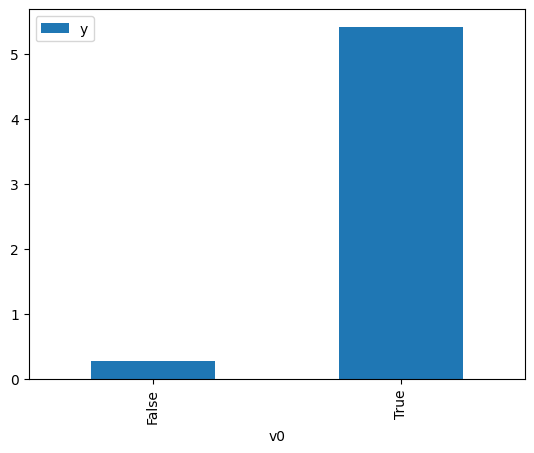

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

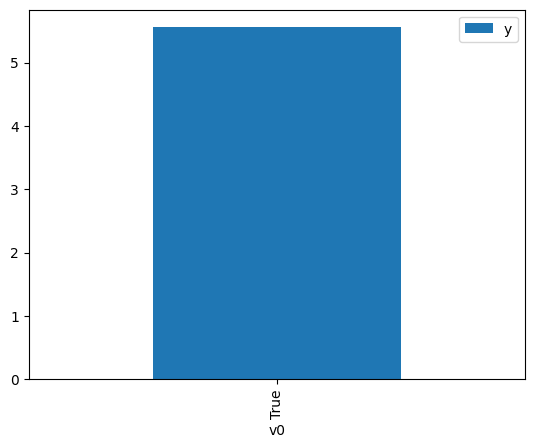

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.643078,False,-2.704844,0.575474,1.737698
1,0.364269,False,0.398325,0.453903,2.203115
2,0.467484,False,0.169603,0.441511,2.264949
3,-1.205890,False,-1.721499,0.640493,1.561297
4,0.132958,False,0.776272,0.481859,2.075297
...,...,...,...,...,...
995,0.700985,False,1.763579,0.413768,2.416816
996,0.830967,False,0.759592,0.398546,2.509121
997,-0.376472,False,-0.966234,0.543581,1.839653
998,-0.309431,False,1.004799,0.535493,1.867436


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.934462,True,2.509268,0.390382,2.561595
1,0.222556,True,4.118211,0.528993,1.890384
2,0.808537,True,6.898139,0.598840,1.669894
3,-0.691401,True,3.105077,0.418804,2.387752
4,1.927998,True,7.220057,0.719949,1.388987
...,...,...,...,...,...
995,1.538043,True,7.092557,0.680237,1.470076
996,1.819745,True,7.667191,0.709230,1.409980
997,0.270639,True,6.407050,0.534806,1.869836
998,-1.084739,True,2.364706,0.373162,2.679805


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          1.010e+04
Date:                Thu, 12 Feb 2026   Prob (F-statistic):                        0.00
Time:                        23:14:14   Log-Likelihood:                         -1431.6
No. Observations:                1000   AIC:                                      2867.
Df Residuals:                     998   BIC:                                      2877.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4550      0.033     44.246      0.000       1.390       1.519
x2             4.9984      0.048    105.087      0.000       4.905       5.092
==============================================================================
Omnibus:                        0.133   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.936   Jarque-Bera (JB):                0.068
Skew:                           0.009   Prob(JB):                        0.967
Kurtosis:                       3.036   Cond. No.                         1.78
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""